In [1]:
%matplotlib inline
%load_ext sql

In [2]:
import itertools
import random
import json
from functools import reduce
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style("whitegrid")
sns.set_context("notebook")

In [4]:
list_to_string = lambda x, y: x + ", " + y

In [5]:
def get_dbconnect_string(json_path, db_interface="postgresql+psycopg2"):
    with open(json_path, "rb") as fd:
        configuration = json.loads(fd.read())
    return db_interface + "://{user}:{password}@{host}:{port}/{database}".format(**configuration)
db_configuration = get_dbconnect_string("database.json")

In [6]:
%%sql $db_configuration
        SELECT MIN(id), MAX(id), COUNT(*) FROM posts

1 rows affected.


min,max,count
1,2900000,2867507


In [7]:
((min_id, max_id, nr_ids),) = _
print("Total posts: {} – From {} to {}".format(nr_ids, min_id, max_id))

Total posts: 2867507 – From 1 to 2900000


In [8]:
posts_columns = %sql SELECT column_name FROM information_schema.columns WHERE table_name = 'posts'

24 rows affected.


In [9]:
print("Columns in posts table:")
print(reduce(list_to_string, (x[0] for x in posts_columns)))

Columns in posts table:
id, created_at, updated_at, uploader_id, score, source, md5, rating, image_width, image_height, file_ext, parent_id, has_children, file_size, up_score, down_score, is_pending, is_flagged, is_deleted, is_banned, pixiv_id, bit_flags, file_url, scraped_at


## Scores

First let's take a look at the ratings users can give to images. This is just for warming up since this is a feature that's not so much used on Danbooru.

In [10]:
scores = %sql SELECT score, COUNT(*) FROM posts GROUP BY score ORDER BY score DESC

256 rows affected.


In [11]:
worst_post = %sql SELECT id FROM posts WHERE score = (SELECT MIN(score) FROM posts)

1 rows affected.


In [12]:
best_post = %sql SELECT id FROM posts WHERE score = (SELECT MAX(score) FROM posts)

1 rows affected.


Text(0.5,1,'Post score distribution')

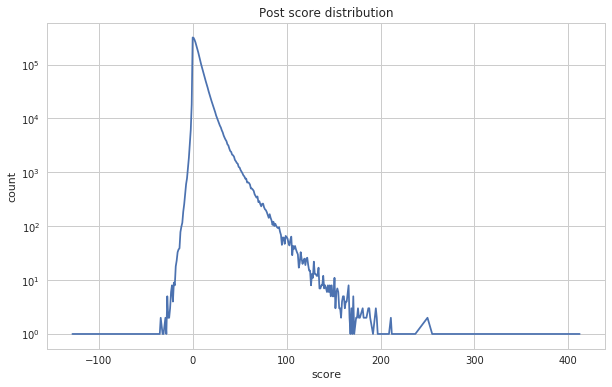

In [13]:
pd_count = scores.DataFrame()["count"]
pd_count.index = scores.DataFrame()["score"]
pd_count.plot(logy=True)
plt.ylabel("count")
plt.title("Post score distribution")

## Status

Now we take a look at the status of the posts since we'll most likely not use deleted or banned posts. We have the following categories:

`is_pending, is_flagged, is_deleted, is_banned`

In [14]:
pending_posts = %sql SELECT id FROM posts WHERE is_pending = true
flagged_posts = %sql SELECT id FROM posts WHERE is_flagged = true
deleted_posts = %sql SELECT id FROM posts WHERE is_deleted = true
banned_posts = %sql SELECT id FROM posts WHERE is_banned = true

0 rows affected.
31 rows affected.
158705 rows affected.
14648 rows affected.


In [15]:
def single_column_to_set(column):
    return set(idx[0] for idx in column)
posts_with_status = map(single_column_to_set, (pending_posts, flagged_posts, deleted_posts, banned_posts))
posts_with_status = list(posts_with_status)

In [16]:
post_flag_count = np.array(list(map(len, posts_with_status)))
post_flag_count_log = post_flag_count.copy()
post_flag_count_log[post_flag_count == 0] = 1
post_flag_count_log = np.log10(post_flag_count_log)

Text(0.5,1,'Post status distribution')

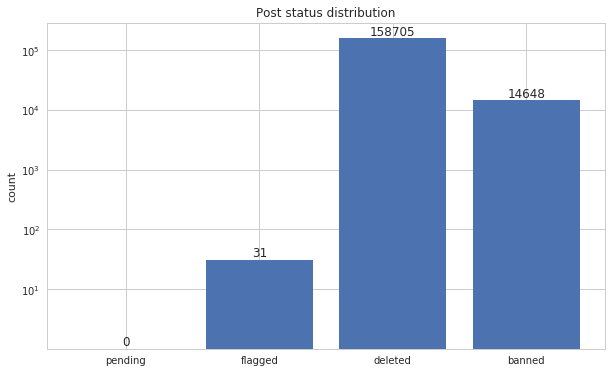

In [17]:
rects = plt.bar(range(4), post_flag_count_log)
plt.xticks(range(4), ["pending", "flagged", "deleted", "banned"])
for idx, rect in enumerate(rects):
    height = rect.get_height()
    width = rect.get_width()
    plt.text(rect.get_x() + width / 2, height, post_flag_count[idx], va="bottom", ha="center")
plt.ylabel("count")
yticks = plt.yticks()[0][1:-1]
plt.yticks(yticks, map(lambda x: "$10^{:d}$".format(int(x)), yticks))
plt.title("Post status distribution")

In [18]:
print("There is a small intersection of deleted and banned posts: %d" % len(posts_with_status[2] & posts_with_status[3]))
print("What is even the difference between these two?")

There is a small intersection of deleted and banned posts: 281
What is even the difference between these two?


Wow, there are a lot of deleted posts. I think I need to check them out manually and their reason for deletion.

But first create a view `filtered_posts` where flagged posts are removed. Furthermore remove children and remove posts where the aspect ration is not in 1:2 to 2:1.

In [19]:
%%sql
CREATE OR REPLACE TEMPORARY VIEW filtered_posts AS
    (SELECT * FROM posts
     WHERE is_pending = false
     AND is_flagged = false
     AND is_deleted = false
     AND is_banned = false
     AND parent_id = 0
     AND (image_width >= 512 OR image_height >= 512)
     AND cast(image_width as double precision) / cast(image_height as double precision) BETWEEN 0.5 AND 2.0)

Done.


[]

In [20]:
filtered_count = %sql SELECT COUNT(*) FROM filtered_posts

1 rows affected.


In [21]:
filtered_ext = %sql SELECT DISTINCT file_ext FROM filtered_posts

8 rows affected.


In [22]:
print("Now after filtering we have %d posts left with the following file extensions:" % filtered_count[0][0])
print(reduce(list_to_string, (x[0] for x in filtered_ext)))

Now after filtering we have 2261400 posts left with the following file extensions:
gif, jpeg, jpg, mp4, png, swf, webm, zip


In [23]:
%%sql
CREATE OR REPLACE TEMPORARY VIEW filtered_images AS
    (SELECT * FROM filtered_posts
     WHERE file_ext = 'jpeg'
     OR file_ext = 'jpg'
     OR file_ext = 'png')

Done.


[]

In [24]:
%sql SELECT COUNT(*) FROM filtered_images

1 rows affected.


count
2248054


## How much R18 content is there on danbooru?

There are three ratings:
* s:safe
* q:questionable
* e:explicit

In [25]:
rating_distribution = %sql SELECT date_trunc('month', created_at) AS month, rating, COUNT(*) FROM posts GROUP BY month, rating ORDER BY month ASC, rating DESC
rating_distribution = np.array(rating_distribution).reshape((150,3,3))
rating_distribution = pd.DataFrame(rating_distribution[:,:,2], columns=rating_distribution[0,:,1], index=rating_distribution[:,0,0], dtype=np.int)

450 rows affected.


Text(0.5,1,'Distribution of uploads over time, grouped by rating')

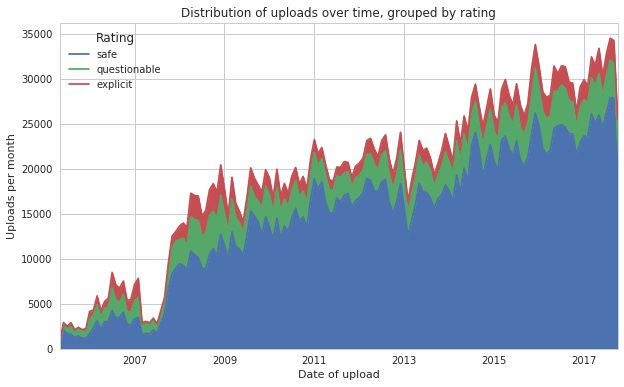

In [26]:
rating_distribution.plot.area()
plt.xlim(rating_distribution.index[0], rating_distribution.index[-1])
plt.legend(["safe", "questionable", "explicit"], title="Rating")
plt.xlabel("Date of upload")
plt.ylabel("Uploads per month")
plt.title("Distribution of uploads over time, grouped by rating")

## How much tags

This is the first interesting thing.

In [27]:
%%sql 
CREATE OR REPLACE TEMPORARY VIEW filtered_tags AS
    (SELECT tags.name, tag_count.count, tags.category
    FROM
        (SELECT tag_id, COUNT(post_id)
         FROM tagged INNER JOIN filtered_images ON filtered_images.id = tagged.post_id
         GROUP BY tag_id) tag_count
    INNER JOIN
        tags ON tags.id = tag_count.tag_id
    ORDER BY tag_count.count DESC)

Done.


[]

### Tags in general

In [28]:
tag_count = %sql SELECT * FROM filtered_tags LIMIT 1000

1000 rows affected.


In [29]:
def list_count(most_popular_tags):
    pop_tag_number = len(most_popular_tags)
    rank_range = list(range(1, pop_tag_number + 1))
    pop_tag_number_length = len(str(pop_tag_number))
    formatter = "{: <30}│{: >10}│{: >9}"
    formatter = "{: >%d}  " % (pop_tag_number_length) + formatter
    print(formatter.format("RANK", "NAME", "COUNT", "CATEGORY"))
    print("─" * (pop_tag_number_length + 2) + "──────────────────────────────┼──────────┼─────────")
    for rank, (name, count, category) in zip(rank_range, most_popular_tags):
        print(formatter.format(rank, name, count, category))

In [30]:
list_count(tag_count)

RANK  NAME                          │     COUNT│ CATEGORY
────────────────────────────────────┼──────────┼─────────
   1  1girl                         │   1570662│        g
   2  solo                          │   1330532│        g
   3  long_hair                     │   1010799│        g
   4  breasts                       │    643865│        g
   5  blush                         │    639725│        g
   6  short_hair                    │    631936│        g
   7  smile                         │    619523│        g
   8  multiple_girls                │    495898│        g
   9  open_mouth                    │    489534│        g
  10  looking_at_viewer             │    471852│        g
  11  touhou                        │    453860│        y
  12  blue_eyes                     │    452116│        g
  13  blonde_hair                   │    447439│        g
  14  brown_hair                    │    417002│        g
  15  skirt                         │    400779│        g
  16  hat     

In [31]:
def plot_count(most_popular_tags, steps, logx=True):
    pop_tag_number = len(most_popular_tags)
    _, pop_tag_count, _ = zip(*most_popular_tags)
    rank_range = list(range(1, pop_tag_number + 1))
    if logx:
        plt.semilogy(rank_range, pop_tag_count)
    else:
        plt.plot(rank_range, pop_tag_count)
    plt.xticks(rank_range[steps-1::steps], rank_range[steps-1::steps])
    plt.xlim(0, pop_tag_number)
    plt.ylabel("count")
    plt.xlabel("rank")
    if logx:
        annotate_line = np.logspace(np.log10(pop_tag_count[steps // 4]), np.log10(pop_tag_count[-1]) * 1.1, 9)
    else:
        annotate_line = np.linspace(pop_tag_count[0] * 0.9, pop_tag_count[steps*9] * 1.1, 9)
    for logy, i in zip(annotate_line, range(0, pop_tag_number - steps, steps)):
        idx = random.randint(i, i + steps - 1)
        random_rank = rank_range[idx]
        random_count = pop_tag_count[idx]
        random_tag = most_popular_tags[idx][0]
        plt.annotate(random_tag, (random_rank, random_count), (i + steps / 2, logy),
                     arrowprops={"arrowstyle":"-|>"})
    plt.title("Distribution of %d most popular tags" % pop_tag_number)

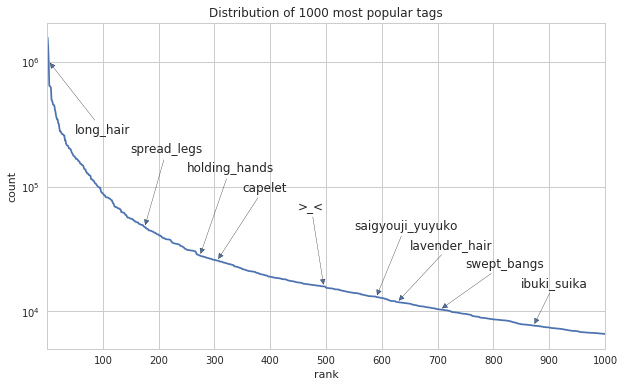

In [32]:
plot_count(tag_count, 100)

Very interesting! Even in log10 space these tags are not really linear distributed. Let's see if we can solve this with preprocessing or if there are some fancy tricks like weighting to take these differences in the distribution into account.

In [33]:
print("Important! These are the top 1000 tags (in descending order) where the word breast is included:")
breast_list = [tag for tag, _, _ in tag_count if tag.find("breast") >= 0]
print(reduce(list_to_string, breast_list))
print("In total these are %d tags!" % len(breast_list))

Important! These are the top 1000 tags (in descending order) where the word breast is included:
breasts, large_breasts, medium_breasts, small_breasts, huge_breasts, breast_grab, breast_press, between_breasts, breast_hold, breasts_outside, cum_on_breasts, covering_breasts
In total these are 12 tags!


In [34]:
def posts_with_tag(tagname):
    tag_id = %sql SELECT id FROM tags WHERE name = :tagname
    tag_id = tag_id[0][0]
    post_id = %sql SELECT post_id FROM tagged WHERE tag_id = :tag_id
    return post_id

In [35]:
posts_with_tag("headphones_on_breasts")

1 rows affected.
9 rows affected.


post_id
460734
472435
596058
1022243
1040917
1062730
1278123
1445451
2666173


### Artists

In [36]:
artist_count = %sql SELECT * FROM filtered_tags WHERE category = 'a' LIMIT 100

100 rows affected.


In [37]:
list_count(artist_count)

RANK  NAME                          │     COUNT│ CATEGORY
───────────────────────────────────┼──────────┼─────────
  1  hammer_(sunset_beach)         │      3548│        a
  2  haruyama_kazunori             │      2808│        a
  3  itomugi-kun                   │      2255│        a
  4  kouji_(campus_life)           │      2020│        a
  5  yohane                        │      1908│        a
  6  ichimi                        │      1717│        a
  7  a1                            │      1702│        a
  8  carnelian                     │      1491│        a
  9  shimazaki_mujirushi           │      1419│        a
 10  kirisawa_juuzou               │      1414│        a
 11  shino_(ponjiyuusu)            │      1411│        a
 12  tonda                         │      1392│        a
 13  warugaki_(sk-ii)              │      1390│        a
 14  dd_(ijigendd)                 │      1385│        a
 15  ueyama_michirou               │      1361│        a
 16  masao                    

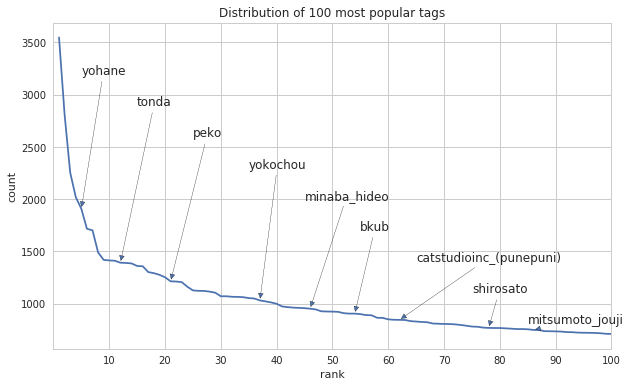

In [38]:
plot_count(artist_count, 10, logx=False)

### Popular anime characters

In [39]:
character_count = %sql SELECT * FROM filtered_tags WHERE category = 'c' LIMIT 100

100 rows affected.


In [40]:
list_count(character_count)

RANK  NAME                          │     COUNT│ CATEGORY
───────────────────────────────────┼──────────┼─────────
  1  hatsune_miku                  │     45989│        c
  2  hakurei_reimu                 │     39238│        c
  3  kirisame_marisa               │     37635│        c
  4  remilia_scarlet               │     28868│        c
  5  izayoi_sakuya                 │     26883│        c
  6  flandre_scarlet               │     25407│        c
  7  alice_margatroid              │     20900│        c
  8  patchouli_knowledge           │     20414│        c
  9  yakumo_yukari                 │     18463│        c
 10  cirno                         │     18453│        c
 11  kochiya_sanae                 │     18422│        c
 12  konpaku_youmu                 │     18088│        c
 13  admiral_(kantai_collection)   │     16874│        c
 14  akemi_homura                  │     16610│        c
 15  fujiwara_no_mokou             │     15784│        c
 16  hong_meiling             

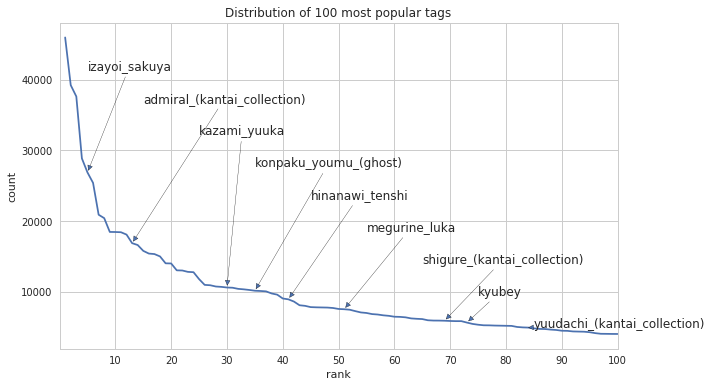

In [41]:
plot_count(character_count, 10, logx=False)

## Popular series

Last but not least.

In [42]:
series_count = %sql SELECT * FROM filtered_tags WHERE category = 'y' LIMIT 100

100 rows affected.


In [43]:
list_count(series_count)

RANK  NAME                          │     COUNT│ CATEGORY
───────────────────────────────────┼──────────┼─────────
  1  touhou                        │    453860│        y
  2  original                      │    264886│        y
  3  kantai_collection             │    201925│        y
  4  vocaloid                      │     69221│        y
  5  idolmaster                    │     68414│        y
  6  fate_(series)                 │     61959│        y
  7  mahou_shoujo_madoka_magica    │     40037│        y
  8  idolmaster_cinderella_girls   │     37799│        y
  9  pokemon                       │     33098│        y
 10  precure                       │     26430│        y
 11  idolmaster_(classic)          │     24270│        y
 12  jojo_no_kimyou_na_bouken      │     24013│        y
 13  fate/grand_order              │     22952│        y
 14  love_live!                    │     22357│        y
 15  pokemon_(game)                │     21204│        y
 16  fate/stay_night          

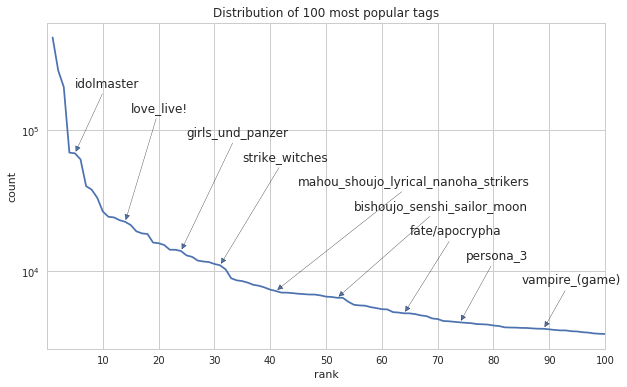

In [44]:
plot_count(series_count, 10)

### Filter out some more tags

There are some tags than can not be easily inferred from just looking on the images, that do not correspont with the use cases I have in mind or that train on useless features. Better to either remove such posts or just remove these tags.

I looked through the first 500 tags from the list above and took note of the following ones:

* monochrome
* **comic**
* greyscale
* alternate_costume
* translated
* artist_request
* sketch
* character_name
* copyright_request
* artist_name
* cosplay
* dated
* signature
* parody
* twitter_username
* copyright_name
* alternate_hairstyle
* **no_humans**
* translation_request
* english
* gradient
* crossover
* doujinshi
* genderswap
* remodel_(kantai_collection)
* game_cg
* cover_page
* official_art
* scan
* text
* **4koma**
* traditional_media
* **3d**
* **photo**
* **lowres**

It might also be a good idea to remove the tags for series (category y) because I don't know why this would be useful. The same for artists but since these are not in the TOP 1000 it should be no problem either way.

### Some more filtering

And now get a list of all the images without the bold marked tags from the last section.

Furthermore we need information about the distribution of the remaining tags etc. and we need to write them into some easily parsable format for further processing with our neural networks.

In [45]:
%%sql
CREATE OR REPLACE TEMPORARY VIEW final_posts AS
SELECT *
FROM filtered_images
WHERE id NOT IN
    (SELECT DISTINCT post_id
     FROM tagged
     WHERE tag_id
     IN
        (SELECT id as tag_id FROM tags
         WHERE name = 'comic'
         OR name = 'no_humans'
         OR name = '4koma'
         OR name = 'photo'
         OR name = '3d'))
ORDER BY id ASC

Done.


[]

In [46]:
final_posts = %sql SELECT id, rating, file_ext FROM final_posts

2061570 rows affected.


In [47]:
%%sql
SELECT tags.id, tags.name, tag_count.count
FROM
(
    SELECT tagged.tag_id, COUNT(tagged.post_id)
    FROM
    final_posts
    INNER JOIN
    tagged
    ON final_posts.id = tagged.post_id
    GROUP BY tagged.tag_id
    HAVING COUNT(tagged.post_id) >= 10000
) tag_count
INNER JOIN
tags
ON tag_count.tag_id = tags.id
WHERE tags.category = 'g'
ORDER BY tag_count.count DESC

615 rows affected.


id,name,count
4,1girl,1523817
36,solo,1314438
18,long_hair,951022
210,breasts,628220
8,blush,601991
59,smile,587298
184,short_hair,581007
20,looking_at_viewer,466356
412,open_mouth,451815
69,blue_eyes,442677


In [48]:
final_tag_count = _

In [49]:
final_posts = np.array(list(map(tuple, final_posts)),
                       dtype=[("id", np.int32), ("rating", "<U1"), ("file_ext", "<U4")])
final_tag_count = np.array(list(map(tuple, final_tag_count)),
                           dtype=[("id", np.int32), ("name", '<U29'), ("count", np.int32)])

In [51]:
pd.DataFrame(final_posts).to_hdf("metadata.h5", "posts", mode="a", complevel=9, complib="bzip2")
pd.DataFrame(final_tag_count).to_hdf("metadata.h5", "tag_count", mode="a", complevel=9, complib="bzip2")